# Gas Storage Prediciton for Europe

In [2]:
import requests
import json
import pandas as pd
import time
import sklearn.linear_model
import sklearn.metrics
import numpy as np
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import scipy.fft
import matplotlib.pyplot as plt

## Using the API to load the data

In [3]:
! curl https://agsi.gie.eu/api?type=eu --header "x-key: <API key>"

{"last_page":146,"total":30,"dataset":"EU","gas_day":"2022-11-29","data":[{"name":"EU","code":"eu","url":"eu","gasDayStart":"2022-11-29","gasInStorage":"1042.5334","consumption":"3776.4337","consumptionFull":"27.61","injection":"186.11","withdrawal":"4504.3","netWithdrawal":"4318.2","workingGasVolume":"1118.7385","injectionCapacity":"11634.01","withdrawalCapacity":"20108.63","status":"E","trend":"-0.39","full":"93.19","info":[]},{"name":"EU","code":"eu","url":"eu","gasDayStart":"2022-11-28","gasInStorage":"1047.0446","consumption":"3776.4337","consumptionFull":"27.73","injection":"178.24","withdrawal":"3493.9","netWithdrawal":"3315.6","workingGasVolume":"1118.7385","injectionCapacity":"11633.99","withdrawalCapacity":"20108.67","status":"C","trend":"-0.3","full":"93.59","info":[]},{"name":"EU","code":"eu","url":"eu","gasDayStart":"2022-11-27","gasInStorage":"1050.5932","consumption":"3776.4337","consumptionFull":"27.82","injection":"723.05","withdrawal":"1322.6","netWithdrawal":"599.5",

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10792    0 10792    0     0  10362      0 --:--:--  0:00:01 --:--:-- 10376


In [4]:
url = "https://agsi.gie.eu/api"
api_key = "<API key>"
params = {
    "type": 'eu',
    "from": '2012-11-01',
    "size": '300',
    "last_page": '159'
}
headers = {"x-key": api_key}

response = requests.get(url, params=params, headers=headers)

In [5]:
response.status_code

200

In [6]:
response.url

'https://agsi.gie.eu/api?type=eu&from=2012-11-01&size=300&last_page=159'

In [7]:
response.json()['data']

[{'name': 'EU',
  'code': 'eu',
  'url': 'eu',
  'gasDayStart': '2022-11-29',
  'gasInStorage': '1042.5334',
  'consumption': '3776.4337',
  'consumptionFull': '27.61',
  'injection': '186.11',
  'withdrawal': '4504.3',
  'netWithdrawal': '4318.2',
  'workingGasVolume': '1118.7385',
  'injectionCapacity': '11634.01',
  'withdrawalCapacity': '20108.63',
  'status': 'E',
  'trend': '-0.39',
  'full': '93.19',
  'info': []},
 {'name': 'EU',
  'code': 'eu',
  'url': 'eu',
  'gasDayStart': '2022-11-28',
  'gasInStorage': '1047.0446',
  'consumption': '3776.4337',
  'consumptionFull': '27.73',
  'injection': '178.24',
  'withdrawal': '3493.9',
  'netWithdrawal': '3315.6',
  'workingGasVolume': '1118.7385',
  'injectionCapacity': '11633.99',
  'withdrawalCapacity': '20108.67',
  'status': 'C',
  'trend': '-0.3',
  'full': '93.59',
  'info': []},
 {'name': 'EU',
  'code': 'eu',
  'url': 'eu',
  'gasDayStart': '2022-11-27',
  'gasInStorage': '1050.5932',
  'consumption': '3776.4337',
  'consump

In [8]:
eu_gas_data = []
for i in range(1,15):
    eu_gas_data.append(requests.get('https://agsi.gie.eu/api', 
                        params={"type": 'eu',
                                "from": '2012-11-01',
                                "size": '300',
                                "page": i},
                        headers = {"x-key": "<API key>"}).json()['data'])

In [9]:
eu_gas_data = sum(eu_gas_data,[])

In [10]:
df_gas = pd.DataFrame(eu_gas_data)

## Data exploration

In [11]:
df_gas

,name,code,url,gasDayStart,gasInStorage,consumption,consumptionFull,injection,withdrawal,netWithdrawal,workingGasVolume,injectionCapacity,withdrawalCapacity,status,trend,full,info
0,EU,eu,eu,2022-11-29,1042.5334,3776.4337,27.61,186.11,4504.3,4318.2,1118.7385,11634.01,20108.63,E,-0.39,93.19,[]
1,EU,eu,eu,2022-11-28,1047.0446,3776.4337,27.73,178.24,3493.9,3315.6,1118.7385,11633.99,20108.67,C,-0.3,93.59,[]
2,EU,eu,eu,2022-11-27,1050.5932,3776.4337,27.82,723.05,1322.6,599.5,1118.7385,11634.07,20108.46,E,-0.05,93.91,[]
3,EU,eu,eu,2022-11-26,1051.0571,3776.4337,27.83,728.58,1405.4,676.8,1118.7385,11634.17,20108.19,E,-0.06,93.95,[]
4,EU,eu,eu,2022-11-25,1051.7473,3776.4337,27.85,366.01,2191.6,1825.5,1118.7385,11634.19,20108.16,E,-0.16,94.01,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3976,EU,eu,eu,2022-02-07,385.887,3776.4337,10.22,464.82,4692,4227.2,1110.5117,11273.32,19478.24,E,-0.38,34.75,[]
3977,EU,eu,eu,2022-02-06,390.086,3776.4337,10.33,778.23,3115.6,2337.3,1110.5107,11273.25,19478.32,E,-0.21,35.13,[]
3978,EU,eu,eu,2022-02-05,392.4993,3776.4337,10.39,734.02,3342.5,2608.5,1110.5107,11273.18,19478.51,E,-0.23,35.34,[]
3979,EU,eu,eu,2022-02-04,395.1141,3776.4337,10.46,720.21,4373,3652.8,1110.5107,11273.18,19478.52,E,-0.33,35.58,[]


In [12]:
df_gas.columns

Index(['name', 'code', 'url', 'gasDayStart', 'gasInStorage', 'consumption',
       'consumptionFull', 'injection', 'withdrawal', 'netWithdrawal',
       'workingGasVolume', 'injectionCapacity', 'withdrawalCapacity', 'status',
       'trend', 'full', 'info'],
      dtype='object')

In [13]:
df_to_plot = df_gas[['gasDayStart','gasInStorage']]

In [14]:
df_to_plot.head()

,gasDayStart,gasInStorage
0,2022-11-29,1042.5334
1,2022-11-28,1047.0446
2,2022-11-27,1050.5932
3,2022-11-26,1051.0571
4,2022-11-25,1051.7473


In [15]:
df_to_plot['gasDayStart'] = pd.to_datetime(df_to_plot['gasDayStart'])

C:\Users\galen\AppData\Local\Temp\ipykernel_52172\4267560474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['gasDayStart'] = pd.to_datetime(df_to_plot['gasDayStart'])


In [16]:
df_to_plot.head()

,gasDayStart,gasInStorage
0,2022-11-29,1042.5334
1,2022-11-28,1047.0446
2,2022-11-27,1050.5932
3,2022-11-26,1051.0571
4,2022-11-25,1051.7473


In [17]:
df_to_plot = df_to_plot.set_index('gasDayStart')

In [18]:
df_to_plot.head()

,gasInStorage
gasDayStart,
2022-11-29,1042.5334
2022-11-28,1047.0446
2022-11-27,1050.5932
2022-11-26,1051.0571
2022-11-25,1051.7473


In [19]:
df_to_plot = df_to_plot.sort_values(by=['gasDayStart'])

In [20]:
df_to_plot['gasInStorage'] = pd.to_numeric(df_to_plot['gasInStorage'],errors = 'coerce')

<AxesSubplot:xlabel='gasDayStart'>

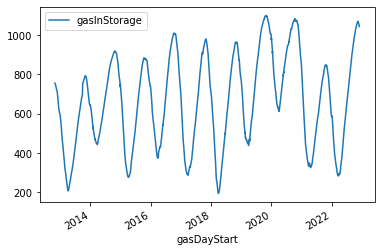

In [21]:
df_to_plot.plot()

## Rolling statistics

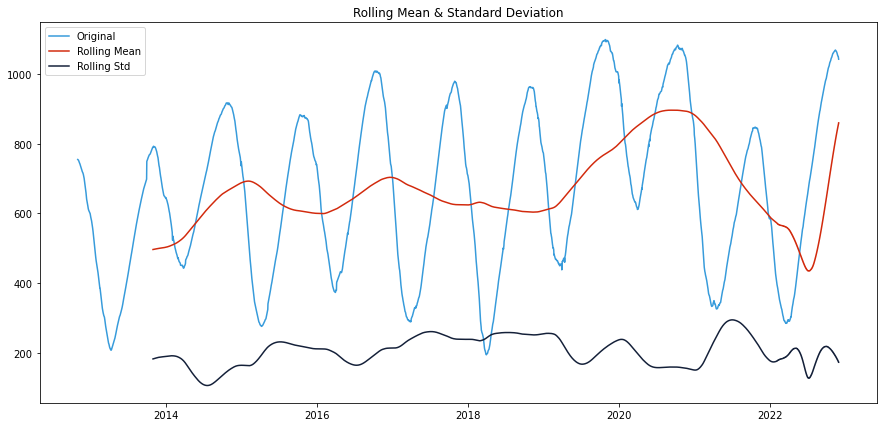

In [24]:
df_rolling = df_to_plot
#Determine rolling statistics
df_rolling["rolling_avg"] = df_rolling["gasInStorage"].rolling(window=365).mean() #window size 365 denotes 365 days, giving rolling mean at yearly level
df_rolling["rolling_std"] = df_rolling["gasInStorage"].rolling(window=365).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_rolling["gasInStorage"], color='#379BDB', label='Original')
plt.plot(df_rolling["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_rolling["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

With the rolling average we can look for trends in the data. There is no obvious trend. Later we will use the Augmented Dickey-Fuller test to prove that our data is stationary.

## Fast Fourier Transform

Since the data is cyclical first I tried to use Fast Fourier Transform to build a model. Below are the steps to determine the periods.

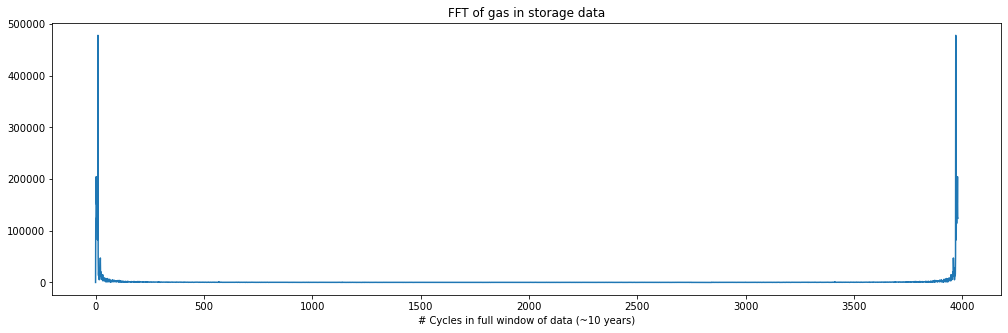

In [26]:
fft = scipy.fft.fft((df_to_plot.gasInStorage - df_to_plot.gasInStorage.mean()).values)

plt.figure(figsize=(17,5))
plt.plot(np.abs(fft))
plt.title("FFT of gas in storage data")
plt.xlabel('# Cycles in full window of data (~10 years)');
plt.show(block=False)

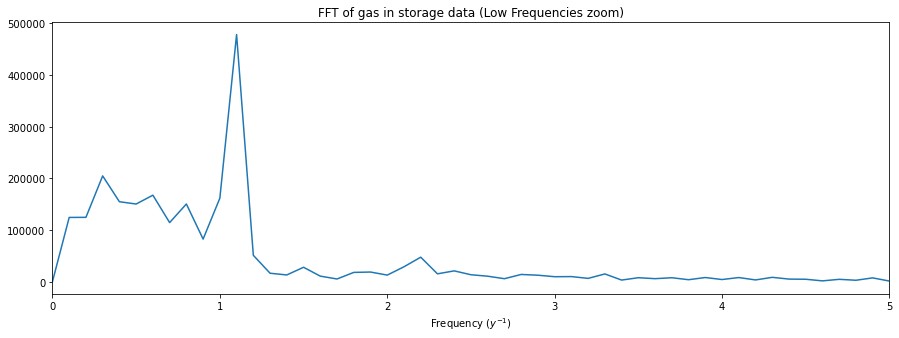

In [27]:
plt.figure(figsize=(15,5))
plt.plot(1./10 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of gas in storage data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)');

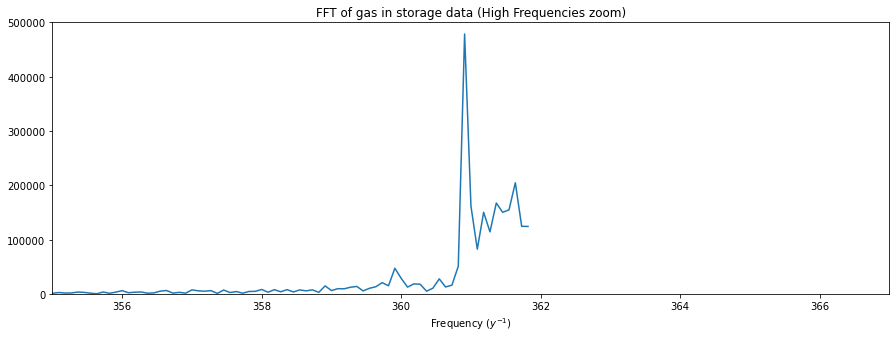

In [28]:
daily_cycles_in_10_years = 11*365.25
plt.figure(figsize=(15,5))
plt.plot(1./11 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of gas in storage data (High Frequencies zoom)")
plt.ylim([0,500000])
plt.xlim([365 - 10, 365 + 2])
plt.xlabel('Frequency ($y^{-1}$)');

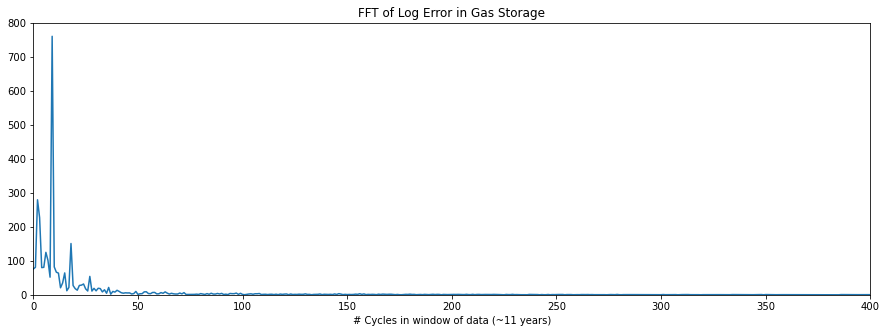

In [29]:
fft = scipy.fft.fft(df_to_plot['Log_Error_Exponential'][(df_to_plot.index.year > 2012) & (df_to_plot.index.year < 2022)].values)
plt.figure(figsize=(15,5))
plt.plot(np.abs(fft))
plt.ylim([0, 800])
plt.xlim([0, 400])
plt.title('FFT of Log Error in Gas Storage')
plt.xlabel('# Cycles in window of data (~11 years)');

There are a yearly and a 6 months period we can observe.

In [30]:
df_gas_fourier = df_to_plot
df_gas_fourier['Julian'] = df_gas_fourier.index.to_julian_date()
df_gas_fourier['Julian'] = df_gas_fourier.index.to_julian_date()
df_gas_fourier['sin(year)'] = np.sin(df_gas_fourier['Julian'] / 365.25 * 2 * np.pi)
df_gas_fourier['cos(year)'] = np.cos(df_gas_fourier['Julian'] / 365.25 * 2 * np.pi)
df_gas_fourier['sin(6mo)'] = np.sin(df_gas_fourier['Julian'] / (365.25 / 2) * 2 * np.pi)
df_gas_fourier['cos(6mo)'] = np.cos(df_gas_fourier['Julian'] / (365.25 / 2) * 2 * np.pi)

In [31]:
df_gas_fourier['Goal'] = df_gas_fourier['gasInStorage'].shift(-30)

1491.6417000719462


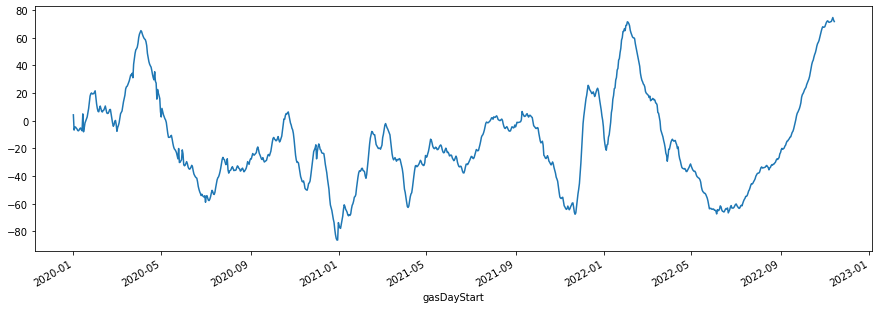

In [117]:
import sklearn.linear_model
import sklearn.metrics

cut_year = 2020

train_fourier = df_gas_fourier[df_gas_fourier.index.year < cut_year].dropna(how='any')
test_fourier  = df_gas_fourier[df_gas_fourier.index.year >= cut_year].dropna(how='any')

fourier = sklearn.linear_model.LinearRegression().fit( 
        X=train_fourier[['gasInStorage', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)']], 
        y=train_fourier['Goal'])

test_fourier['Predicted_Value'] = fourier.predict(X=test_fourier[['gasInStorage', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)']] )

plt.figure(figsize=(15,5))
(test_fourier['Goal'] - test_fourier['Predicted_Value']).plot()
print(sklearn.metrics.mean_squared_error(test_fourier['Goal'], test_fourier['Predicted_Value']))

After trying several models, this Fourier model still performs very poorly. Let's see how the ARIMA model will work.

## ARIMA models

In [33]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [35]:
gas = pd.Series(df_gas['gasInStorage'].astype(float).values, index=df_gas['gasDayStart']).sort_index()

In [36]:
gas.head()

gasDayStart
2012-11-01    754.5624
2012-11-02    753.8222
2012-11-03    753.4001
2012-11-04    753.0005
2012-11-05    751.8834
dtype: float64

### AR model

In [37]:
armodel = pm.ARIMA((2,0,0), suppress_warnings=True)
armodel.fit(gas)

ARIMA(order=(2, 0, 0), suppress_warnings=True)

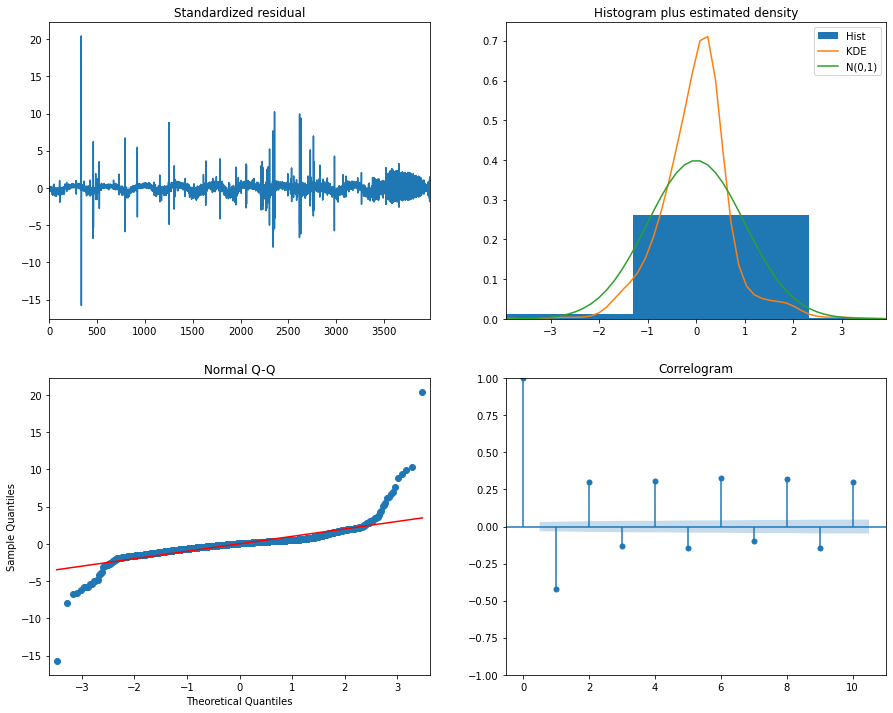

In [89]:
armodel.plot_diagnostics(figsize=(15,12))
plt.show()

R^2: 0.9998964044286119, MSE: 5.962289994980777


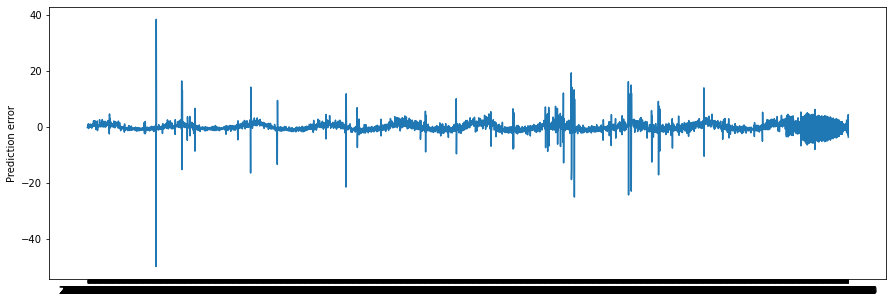

In [38]:
# Get the predictions for the data points we trained on
predictions = armodel.predict_in_sample()

plt.figure(figsize=(15,5))
plt.plot(predictions[2:] - gas[2:]);
plt.ylabel("Prediction error")

r2 = r2_score(predictions[2:], gas[2:])
mse = mean_squared_error(predictions[2:], gas[2:])
print("R^2: {}, MSE: {}".format(r2, mse))

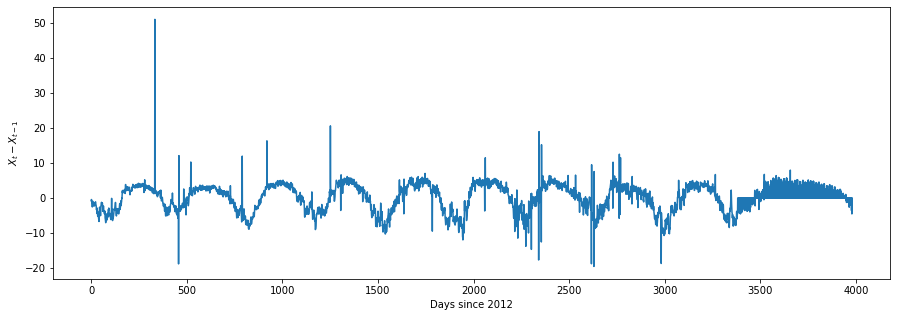

In [39]:
plt.figure(figsize=(15,5))
plt.plot(pm.utils.diff(gas, lag=1, differences=1))
plt.xlabel("Days since 2012")
plt.ylabel("$X_{t} - X_{t-1}$");

As we can see from the plots, this model is not the best fit for our data.

### ARIMA model

R^2: 0.9999344282230116, MSE: 3.7806595214230128


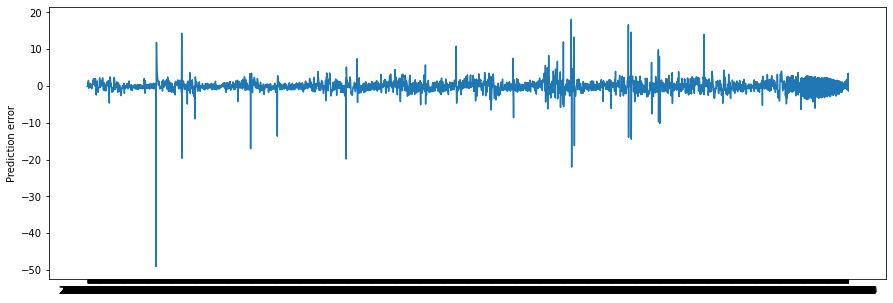

In [40]:
arima211 = pm.ARIMA((2,1,1), suppress_warnings=True)
arima211.fit(gas)

predictions = arima211.predict_in_sample()

plt.figure(figsize=(15,5))
plt.plot(predictions[2:] - gas[2:]);
plt.ylabel("Prediction error")

r2 = r2_score(predictions[2:], gas[2:])
mse = mean_squared_error(predictions[2:], gas[2:])
print("R^2: {}, MSE: {}".format(r2, mse))

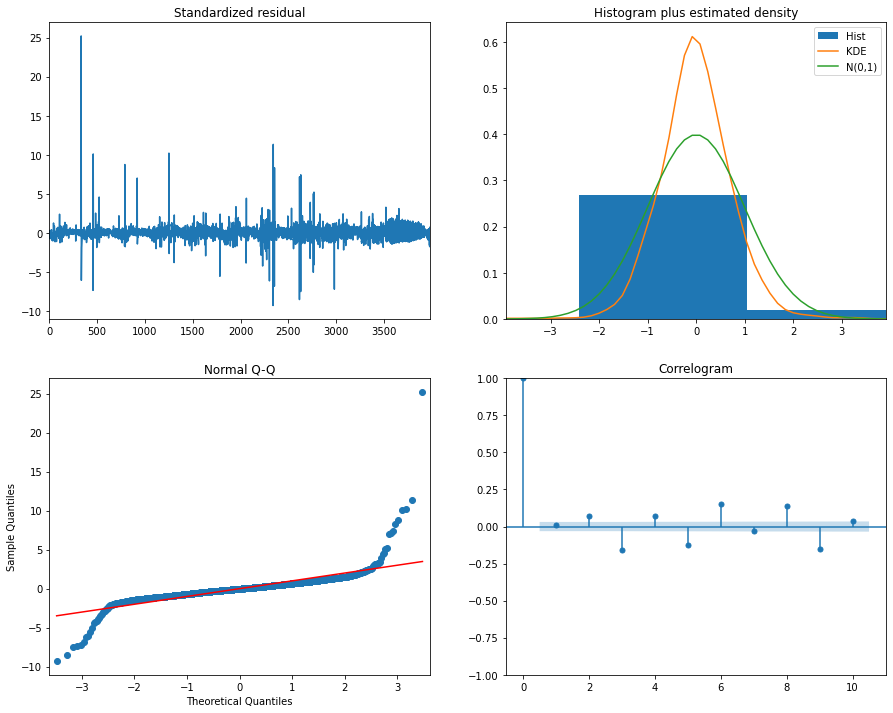

In [88]:
arima211.plot_diagnostics(figsize=(15,12))
plt.show()

Based on the diagnostics, the arima(2,1,1) model seems to be performing a little better but still not the best fit.

### Auto ARIMA

We can use Auto ARIMA to find the best possible ARIMA model for our data.

In [41]:
train_arima = gas[:-365].values
test_arima = gas[-365:].values

In [42]:
model = pm.auto_arima(train_arima, suppress_warnings=True)

In [43]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 4),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

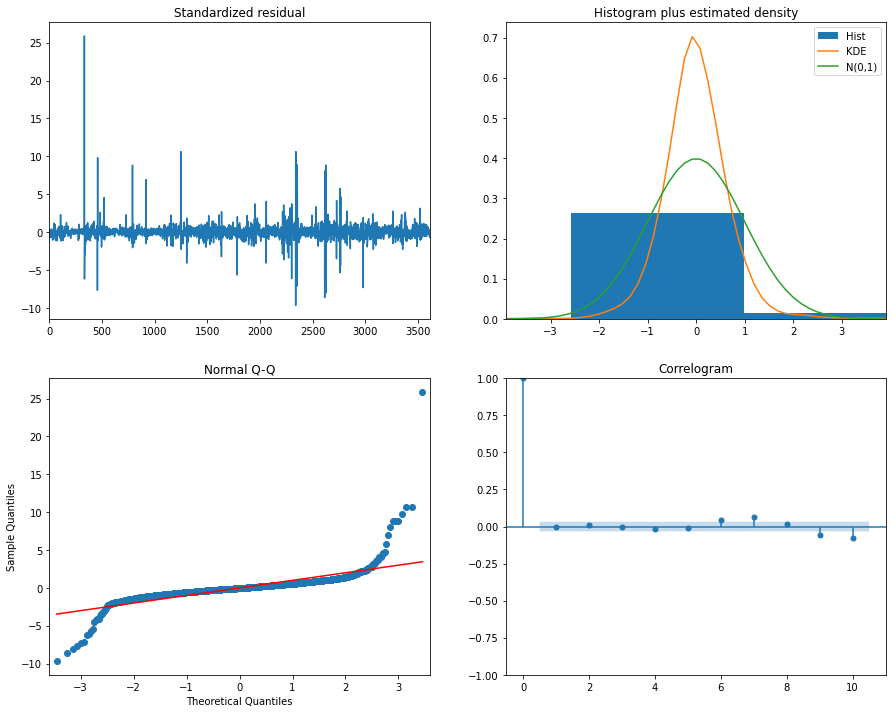

In [87]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [44]:
in_sample = model.predict_in_sample()
test_predictions = model.predict(n_periods=365)

R^2: 0.9999352449203295, MSE: 3.6378574098640786


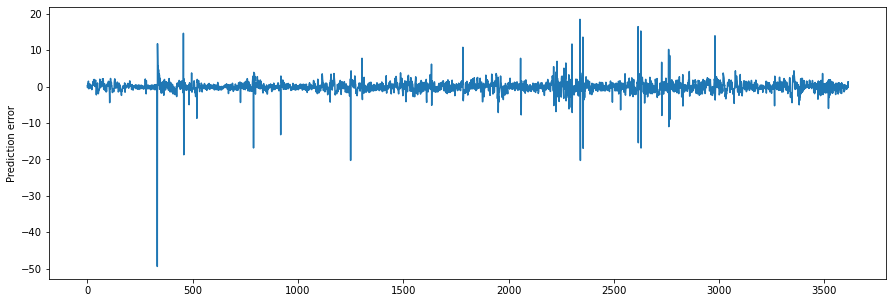

In [45]:
plt.figure(figsize=(15,5))
plt.plot(in_sample[2:] - train_arima[2:]);
plt.ylabel("Prediction error")

r2 = r2_score(in_sample[2:], train_arima[2:])
mse = mean_squared_error(in_sample[2:], train_arima[2:])
print("R^2: {}, MSE: {}".format(r2, mse))

R^2: -35.958605222121605, MSE: 218904.36712250384


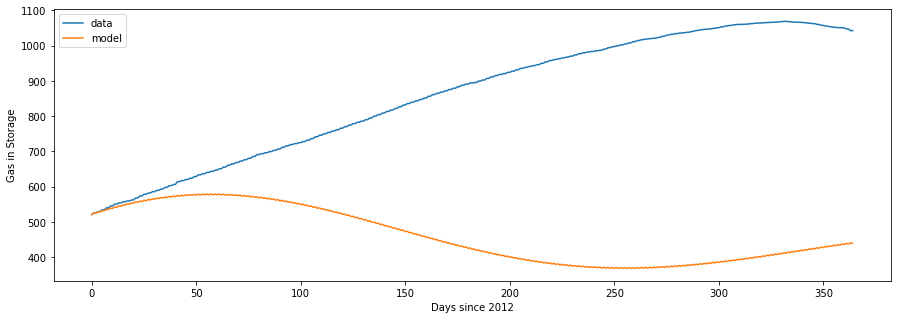

In [46]:
plt.figure(figsize=(15,5))
plt.plot(test_arima, label='data')
plt.plot(test_predictions, label='model')
plt.legend()
plt.ylabel("Gas in Storage")
plt.xlabel("Days since 2012")

r2 = r2_score(test_predictions, test_arima)
mse = mean_squared_error(test_predictions, test_arima)
print("R^2: {}, MSE: {}".format(r2, mse))

Here we can see what the problem can be when it comes to arima models. With time increasing, the model performs worse.

In [48]:
gas_model = pm.auto_arima(gas, start_p=1, start_q=1, suppress_warnings=True)

In [49]:
gas_in_sample = gas_model.predict_in_sample()

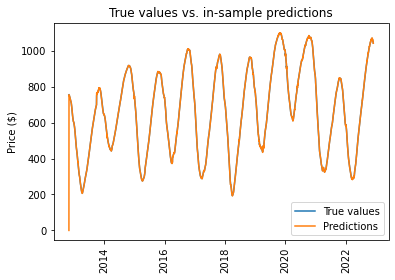

In [50]:
fig, ax = plt.subplots()
plt.plot(df_to_plot.index, df_to_plot.gasInStorage, label="True values")
plt.plot(df_to_plot.index, gas_in_sample, label="Predictions")
plt.title('True values vs. in-sample predictions')
plt.legend(loc='lower right')
plt.xticks(rotation=90)
ax.set_ylabel('Price ($)')
plt.show();

MSE: 146.41322361109874


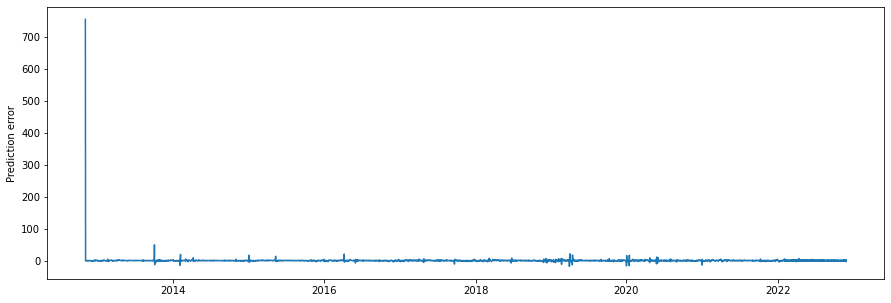

In [51]:
plt.figure(figsize=(15,5))
plt.plot(df_to_plot.index, df_to_plot.gasInStorage.values - gas_in_sample)
plt.ylabel("Prediction error")
print("MSE: {}".format(mean_squared_error(df_to_plot.gasInStorage, gas_in_sample)))

In [52]:
gas_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

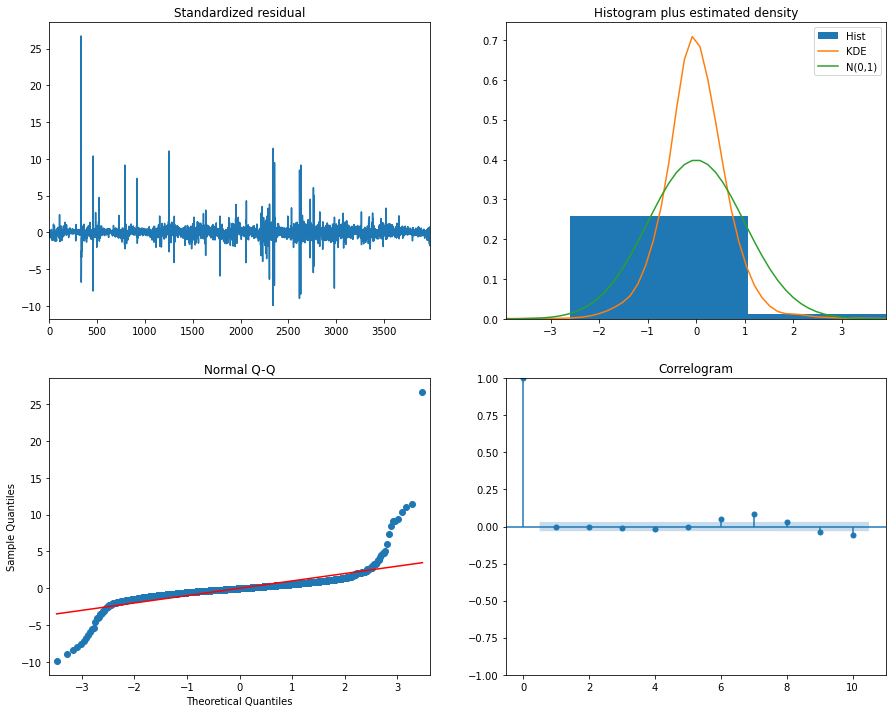

In [86]:
gas_model.plot_diagnostics(figsize=(15,12))
plt.show()

Mean of differences: 0.07235452261306527



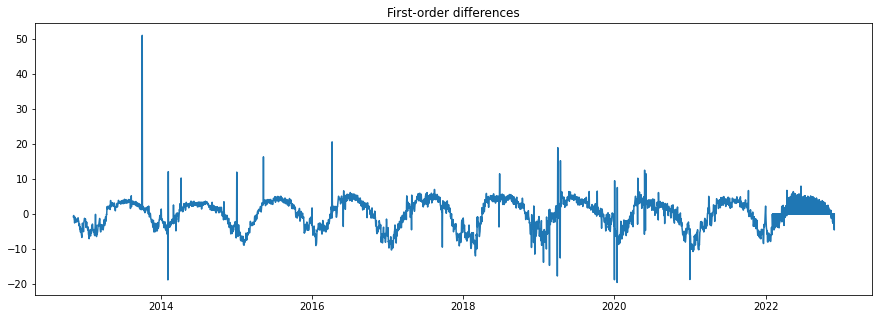

In [53]:
diff = pm.utils.diff(df_to_plot.gasInStorage, lag=1, differences=1)
print(f'Mean of differences: {diff.mean()}\n')

plt.figure(figsize=(15,5))
plt.plot(df_to_plot.index[1:], diff)
plt.title('First-order differences');

## SARIMA model

In [59]:
df_gas_month = df_to_plot.resample('1M').mean()

In [75]:
gas_month = pd.Series(df_gas_month['gasInStorage'].astype(float).values, index=df_gas_month.index).sort_index()

In [76]:
gas_month.head()

gasDayStart
2012-11-30    733.364963
2012-12-31    641.802348
2013-01-31    531.346171
2013-02-28    393.427107
2013-03-31    275.837829
Freq: M, dtype: float64

In [77]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(gas_month, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -4.031544
p-value                          0.001254
#Lags Used                      12.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


The p-value is close to zero which tells us that our data is stationary. This is good because this is what the arima model assumes.

In [120]:
test_size = 24

train_month = gas_month[:-test_size]
test_month = gas_month[-test_size:]

In [119]:
seasonal_model = pm.auto_arima(train_month, 
                      start_p=1, start_q=0, max_p=3, max_q=3,
                      start_P=1, start_Q=0, max_P=3, max_Q=3,
                      seasonal=True, m=12, suppress_warnings=True, error_action="ignore")

In [80]:
seasonal_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [81]:
in_sample = seasonal_model.predict_in_sample()
test_predictions = seasonal_model.predict(n_periods=test_size)

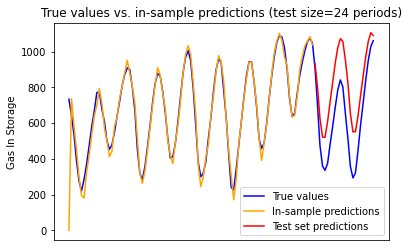

In [82]:
fig, ax = plt.subplots()
plt.plot(gas_month.index, gas_month.values, label='True values',color='b')
plt.plot(gas_month.index[:-test_size], in_sample, label='In-sample predictions',color='orange')
plt.plot(gas_month.index[-test_size:], test_predictions, label='Test set predictions', color='r')
plt.title(f'True values vs. in-sample predictions (test size={test_size} periods)')
plt.legend(loc='lower right')
ax.set_ylabel('Gas In Storage')
ax.set_xticks(ax.get_xticks()[::20])
plt.xticks(rotation=90);

In [123]:
r2 = r2_score(in_sample[2:], train_month[2:])
print("R^2: {}".format(r2))

R^2: 0.9835202291010177


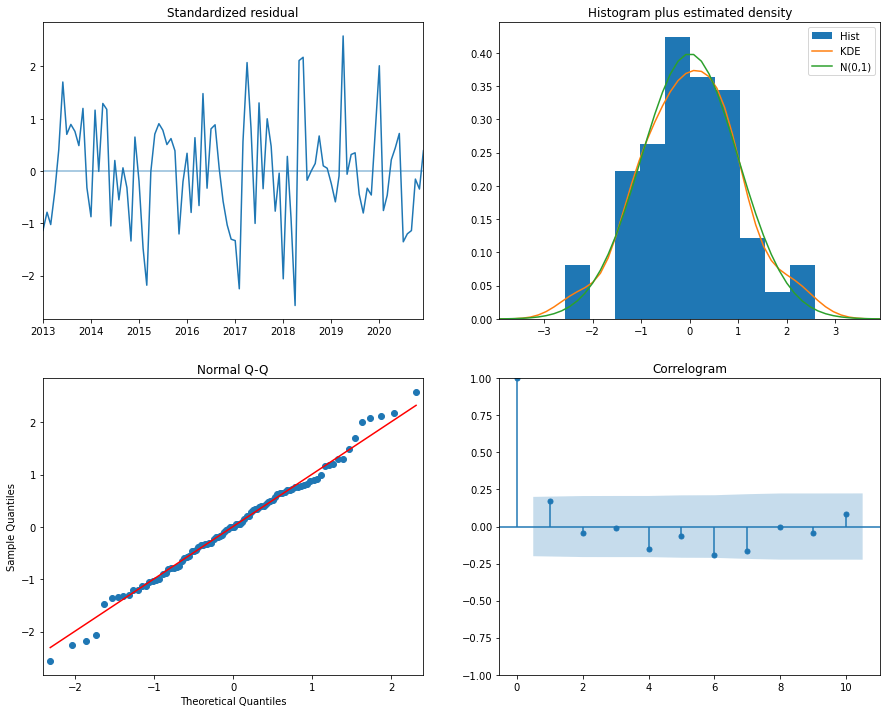

In [85]:
seasonal_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Conclusion

After trying several models, like linear regression with fast Fourier transformation, AR model, ARIMA models and SARIMA model. The SARIMA model seems to be the best fit for our data. And with that we can say that for this winter Europe will have sufficient amount of gas for energy.

## References

- Aggregated Gas Storage Inventory: https://agsi.gie.eu/
- Time Series Forecasting with ARIMA , SARIMA and SARIMAX: https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
- Forecasting Electricity Demand for Turkey via a Modulated Fourier Expansion: https://arxiv.org/ftp/arxiv/papers/2003/2003.13385.pdf
- Natural gas storage level forecasting using temperature data: http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1469385&dswid=-9699
- Data-driven based machine learning models for predicting the deliverability of underground natural gas storage in salt caverns: https://www.sciencedirect.com/science/article/abs/pii/S0360544221008975
- US natural gas consumption prediction using an improved kernel-based nonlinear extension of the Arps decline model: https://www.sciencedirect.com/science/article/abs/pii/S0360544220300128
- Daily Temperature of Major Cities: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities